# Comprehensive Model Comparison & Analysis
## Speech-Only Features: All Models, All Targets

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Load Data and Prepare Features

In [12]:
# Load preprocessed data (speech-only features)
df = pd.read_csv('../data/preprocessed_final.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset loaded: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")

# Define columns
metadata_cols = ['date', 'next_trading_day', 'speaker']
target_cols = [c for c in df.columns if c.startswith('target_') or c.startswith('class_')]
feature_cols = [c for c in df.columns if c not in metadata_cols + target_cols]

print(f"\nFeatures: {len(feature_cols)} (speech-only, market features removed)")
print(f"Targets: {len(target_cols)}")

# Prepare features
X = df[feature_cols].copy()

# Time-based split (80/20)
split_index = int(len(df) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Dataset loaded: (1785, 52)
Date range: 1996-06-13 to 2020-02-27

Features: 33 (speech-only, market features removed)
Targets: 16

Training samples: 1428
Testing samples: 357


## 2. Train All Models on Both Targets

In [13]:
# Storage for all results
all_results = []

# Define targets
targets = {
    '1-Day Binary': (df['target_SP500_1d'] > 0).astype(int),
    '5-Day Binary': (df['target_SP500_5d'] > 0).astype(int)
}

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42, solver='lbfgs', C=1.0),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )
}

print("Training all models on both targets...\n")
print("="*100)

Training all models on both targets...



In [14]:
# Train and evaluate all combinations
for target_name, y in targets.items():
    print(f"\n{'='*100}")
    print(f"TARGET: {target_name}")
    print("="*100)
    
    # Split target
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]
    
    # Calculate baseline
    baseline_class = y_train.mode()[0]
    baseline_acc = accuracy_score(y_test, np.full(len(y_test), baseline_class))
    
    print(f"\nTarget Distribution:")
    print(f"  Training: Up={y_train.sum()} ({y_train.mean():.1%}), Down={len(y_train)-y_train.sum()} ({1-y_train.mean():.1%})")
    print(f"  Testing:  Up={y_test.sum()} ({y_test.mean():.1%}), Down={len(y_test)-y_test.sum()} ({1-y_test.mean():.1%})")
    print(f"  Baseline (always predict {'Up' if baseline_class==1 else 'Down'}): {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for model_name, model in models.items():
        print(f"\n{'-'*100}")
        print(f"Training: {model_name}")
        print("-"*100)
        
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Get predictions and probabilities
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Test multiple thresholds
        best_acc = 0
        best_threshold = 0.5
        best_metrics = {}
        
        print("\nTesting thresholds:")
        for threshold in [0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70]:
            y_pred = (y_pred_proba >= threshold).astype(int)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='binary')
            
            print(f"  {threshold:.2f}: Acc={acc:.4f}, F1={f1:.4f}")
            
            if acc > best_acc:
                best_acc = acc
                best_threshold = threshold
                best_y_pred = y_pred
                best_metrics = {
                    'accuracy': acc,
                    'precision': precision_score(y_test, y_pred, zero_division=0),
                    'recall': recall_score(y_test, y_pred, zero_division=0),
                    'f1': f1,
                    'confusion_matrix': confusion_matrix(y_test, y_pred)
                }
        
        # Store results
        result = {
            'Model': model_name,
            'Target': target_name,
            'Baseline': baseline_acc,
            'Threshold': best_threshold,
            'Accuracy': best_metrics['accuracy'],
            'Precision': best_metrics['precision'],
            'Recall': best_metrics['recall'],
            'F1 Score': best_metrics['f1'],
            'vs Baseline': best_metrics['accuracy'] - baseline_acc,
            'Beats Baseline': best_metrics['accuracy'] > baseline_acc,
            'Confusion Matrix': best_metrics['confusion_matrix'],
            'Predictions': best_y_pred,
            'True Labels': y_test.values
        }
        all_results.append(result)
        
        # Print summary
        print(f"\n{'*'*100}")
        print(f"BEST RESULT: {model_name} on {target_name}")
        print("*"*100)
        print(f"Optimal Threshold: {best_threshold:.2f}")
        print(f"Accuracy:  {best_metrics['accuracy']:.4f} ({best_metrics['accuracy']*100:.2f}%)")
        print(f"Precision: {best_metrics['precision']:.4f}")
        print(f"Recall:    {best_metrics['recall']:.4f}")
        print(f"F1 Score:  {best_metrics['f1']:.4f}")
        print(f"Baseline:  {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")
        print(f"vs Baseline: {(best_metrics['accuracy'] - baseline_acc)*100:+.2f}%")
        if best_metrics['accuracy'] > baseline_acc:
            print(f"✅ BEATS BASELINE by {(best_metrics['accuracy'] - baseline_acc)*100:.2f}%")
        else:
            print(f"❌ Below baseline by {(baseline_acc - best_metrics['accuracy'])*100:.2f}%")
        print("*"*100)

print("\n" + "="*100)
print("ALL MODELS TRAINED!")
print("="*100)


TARGET: 1-Day Binary

Target Distribution:
  Training: Up=800 (56.0%), Down=628 (44.0%)
  Testing:  Up=192 (53.8%), Down=165 (46.2%)
  Baseline (always predict Up): 0.5378 (53.78%)

----------------------------------------------------------------------------------------------------
Training: Logistic Regression
----------------------------------------------------------------------------------------------------

Testing thresholds:
  0.30: Acc=0.5378, F1=0.6995
  0.35: Acc=0.5406, F1=0.7007
  0.40: Acc=0.5378, F1=0.6972
  0.45: Acc=0.5434, F1=0.6953
  0.50: Acc=0.5070, F1=0.6494
  0.55: Acc=0.5518, F1=0.5980
  0.60: Acc=0.5182, F1=0.4267
  0.65: Acc=0.4678, F1=0.1441
  0.70: Acc=0.4678, F1=0.0500

****************************************************************************************************
BEST RESULT: Logistic Regression on 1-Day Binary
****************************************************************************************************
Optimal Threshold: 0.55
Accuracy:  0.5518 

## 3. Comprehensive Results Table

In [15]:
# Create results DataFrame
results_df = pd.DataFrame([{
    'Model': r['Model'],
    'Target': r['Target'],
    'Threshold': r['Threshold'],
    'Accuracy': r['Accuracy'],
    'Precision': r['Precision'],
    'Recall': r['Recall'],
    'F1 Score': r['F1 Score'],
    'Baseline': r['Baseline'],
    'vs Baseline': r['vs Baseline'],
    'Beats Baseline': '✅' if r['Beats Baseline'] else '❌'
} for r in all_results])

# Sort by accuracy descending
results_df = results_df.sort_values('Accuracy', ascending=False)

print("="*120)
print(" "*40 + "COMPREHENSIVE MODEL COMPARISON")
print("="*120)
print(results_df.to_string(index=False))
print("="*120)

                                        COMPREHENSIVE MODEL COMPARISON
              Model       Target  Threshold  Accuracy  Precision   Recall  F1 Score  Baseline  vs Baseline Beats Baseline
Logistic Regression 5-Day Binary       0.50  0.588235   0.583569 1.000000  0.737030  0.577031     0.011204              ✅
      Random Forest 5-Day Binary       0.30  0.577031   0.577031 1.000000  0.731794  0.577031     0.000000              ❌
            XGBoost 5-Day Binary       0.30  0.571429   0.577259 0.961165  0.721311  0.577031    -0.005602              ❌
Logistic Regression 1-Day Binary       0.55  0.551821   0.577670 0.619792  0.597990  0.537815     0.014006              ✅
      Random Forest 1-Day Binary       0.40  0.551821   0.548193 0.947917  0.694656  0.537815     0.014006              ✅
            XGBoost 1-Day Binary       0.30  0.540616   0.546980 0.848958  0.665306  0.537815     0.002801              ✅


## 4. Performance Metrics Visualization

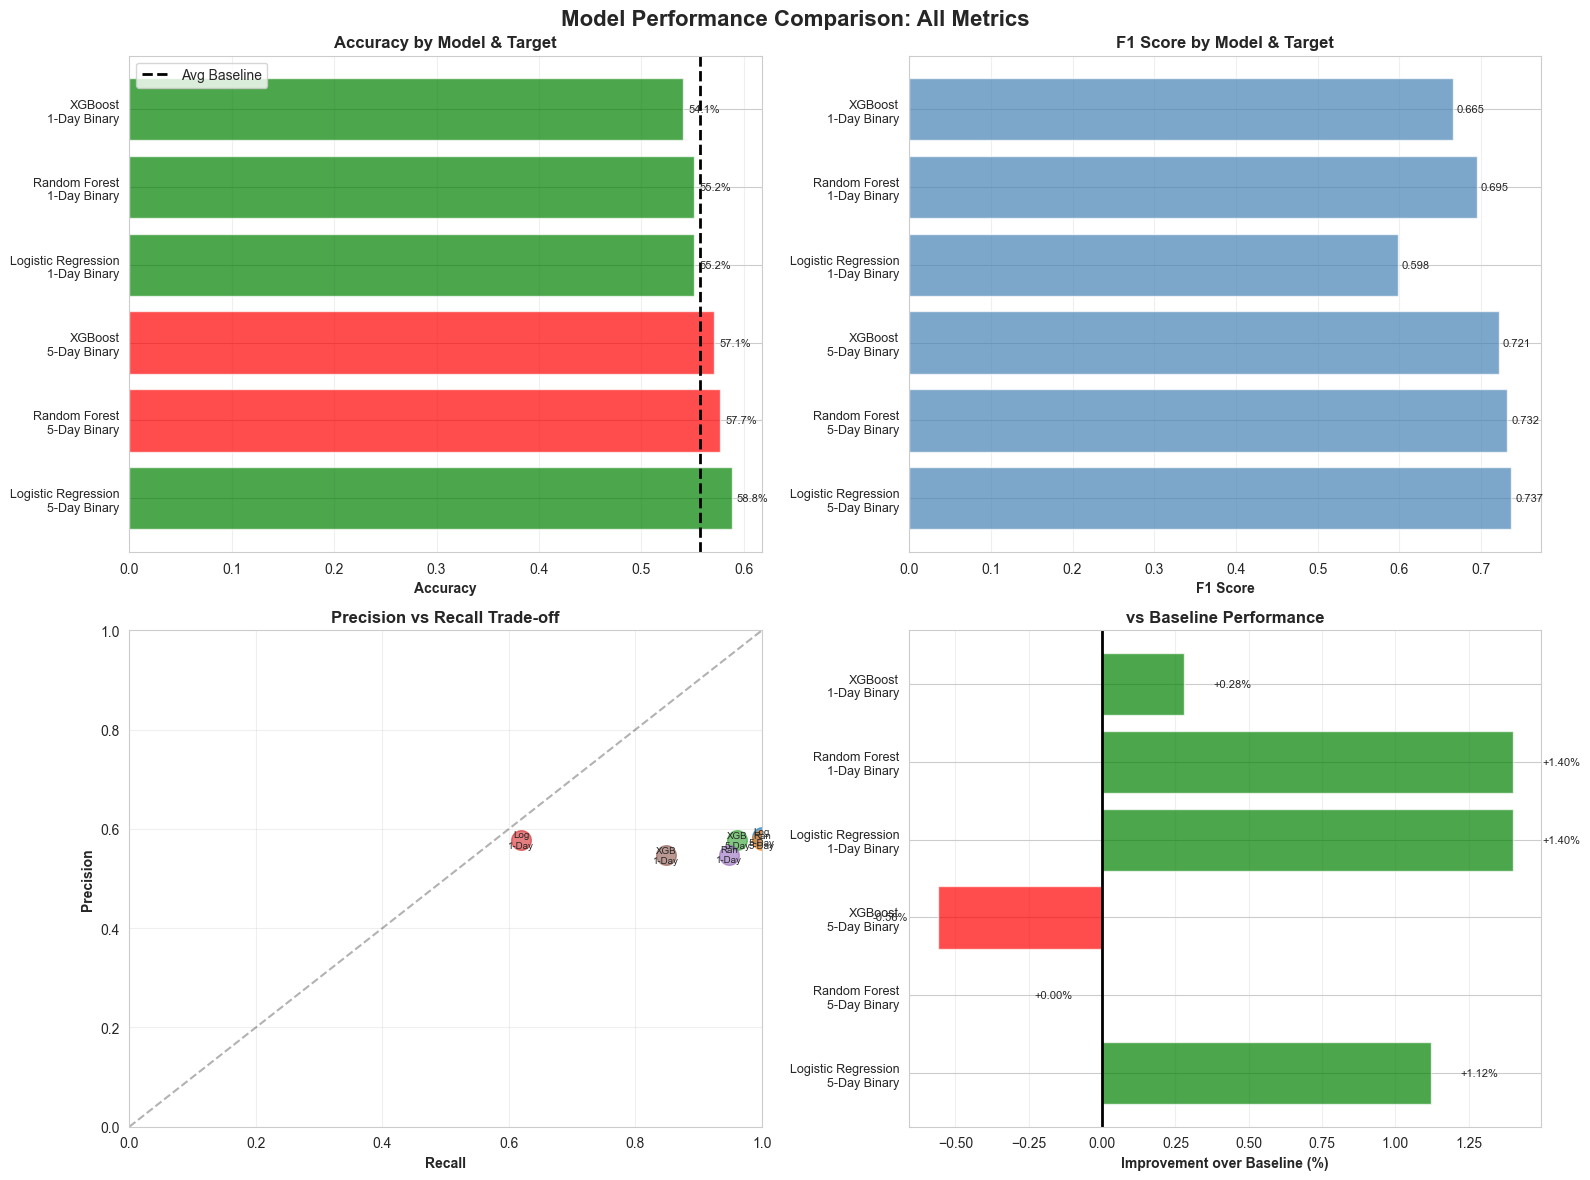


📊 Performance metrics visualized!


In [16]:
# Create subplots for different metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison: All Metrics', fontsize=16, fontweight='bold')

# Prepare data for plotting
results_df['Model_Target'] = results_df['Model'] + '\n' + results_df['Target']

# 1. Accuracy Comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(results_df))
colors = ['green' if beat == '✅' else 'red' for beat in results_df['Beats Baseline']]
ax1.barh(x_pos, results_df['Accuracy'], color=colors, alpha=0.7)
ax1.axvline(x=results_df['Baseline'].mean(), color='black', linestyle='--', linewidth=2, label='Avg Baseline')
ax1.set_yticks(x_pos)
ax1.set_yticklabels(results_df['Model_Target'], fontsize=9)
ax1.set_xlabel('Accuracy', fontweight='bold')
ax1.set_title('Accuracy by Model & Target', fontweight='bold')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)
for i, (acc, baseline) in enumerate(zip(results_df['Accuracy'], results_df['Baseline'])):
    ax1.text(acc + 0.005, i, f'{acc:.1%}', va='center', fontsize=8)

# 2. F1 Score Comparison
ax2 = axes[0, 1]
ax2.barh(x_pos, results_df['F1 Score'], color='steelblue', alpha=0.7)
ax2.set_yticks(x_pos)
ax2.set_yticklabels(results_df['Model_Target'], fontsize=9)
ax2.set_xlabel('F1 Score', fontweight='bold')
ax2.set_title('F1 Score by Model & Target', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, f1 in enumerate(results_df['F1 Score']):
    ax2.text(f1 + 0.005, i, f'{f1:.3f}', va='center', fontsize=8)

# 3. Precision vs Recall
ax3 = axes[1, 0]
for i, row in results_df.iterrows():
    ax3.scatter(row['Recall'], row['Precision'], s=200, alpha=0.6, 
               label=f"{row['Model']}\n{row['Target']}")
    ax3.annotate(f"{row['Model'][:3]}\n{row['Target'][:5]}", 
                (row['Recall'], row['Precision']), 
                fontsize=7, ha='center', va='center')
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect Balance')
ax3.set_xlabel('Recall', fontweight='bold')
ax3.set_ylabel('Precision', fontweight='bold')
ax3.set_title('Precision vs Recall Trade-off', fontweight='bold')
ax3.grid(alpha=0.3)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)

# 4. Improvement over Baseline
ax4 = axes[1, 1]
improvement = results_df['vs Baseline'] * 100
colors4 = ['green' if x > 0 else 'red' for x in improvement]
ax4.barh(x_pos, improvement, color=colors4, alpha=0.7)
ax4.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax4.set_yticks(x_pos)
ax4.set_yticklabels(results_df['Model_Target'], fontsize=9)
ax4.set_xlabel('Improvement over Baseline (%)', fontweight='bold')
ax4.set_title('vs Baseline Performance', fontweight='bold')
ax4.grid(axis='x', alpha=0.3)
for i, imp in enumerate(improvement):
    ax4.text(imp + 0.1 if imp > 0 else imp - 0.1, i, f'{imp:+.2f}%', 
            va='center', ha='left' if imp > 0 else 'right', fontsize=8)

plt.tight_layout()
plt.show()

print("\n📊 Performance metrics visualized!")

## 5. Confusion Matrices - All Models & Targets

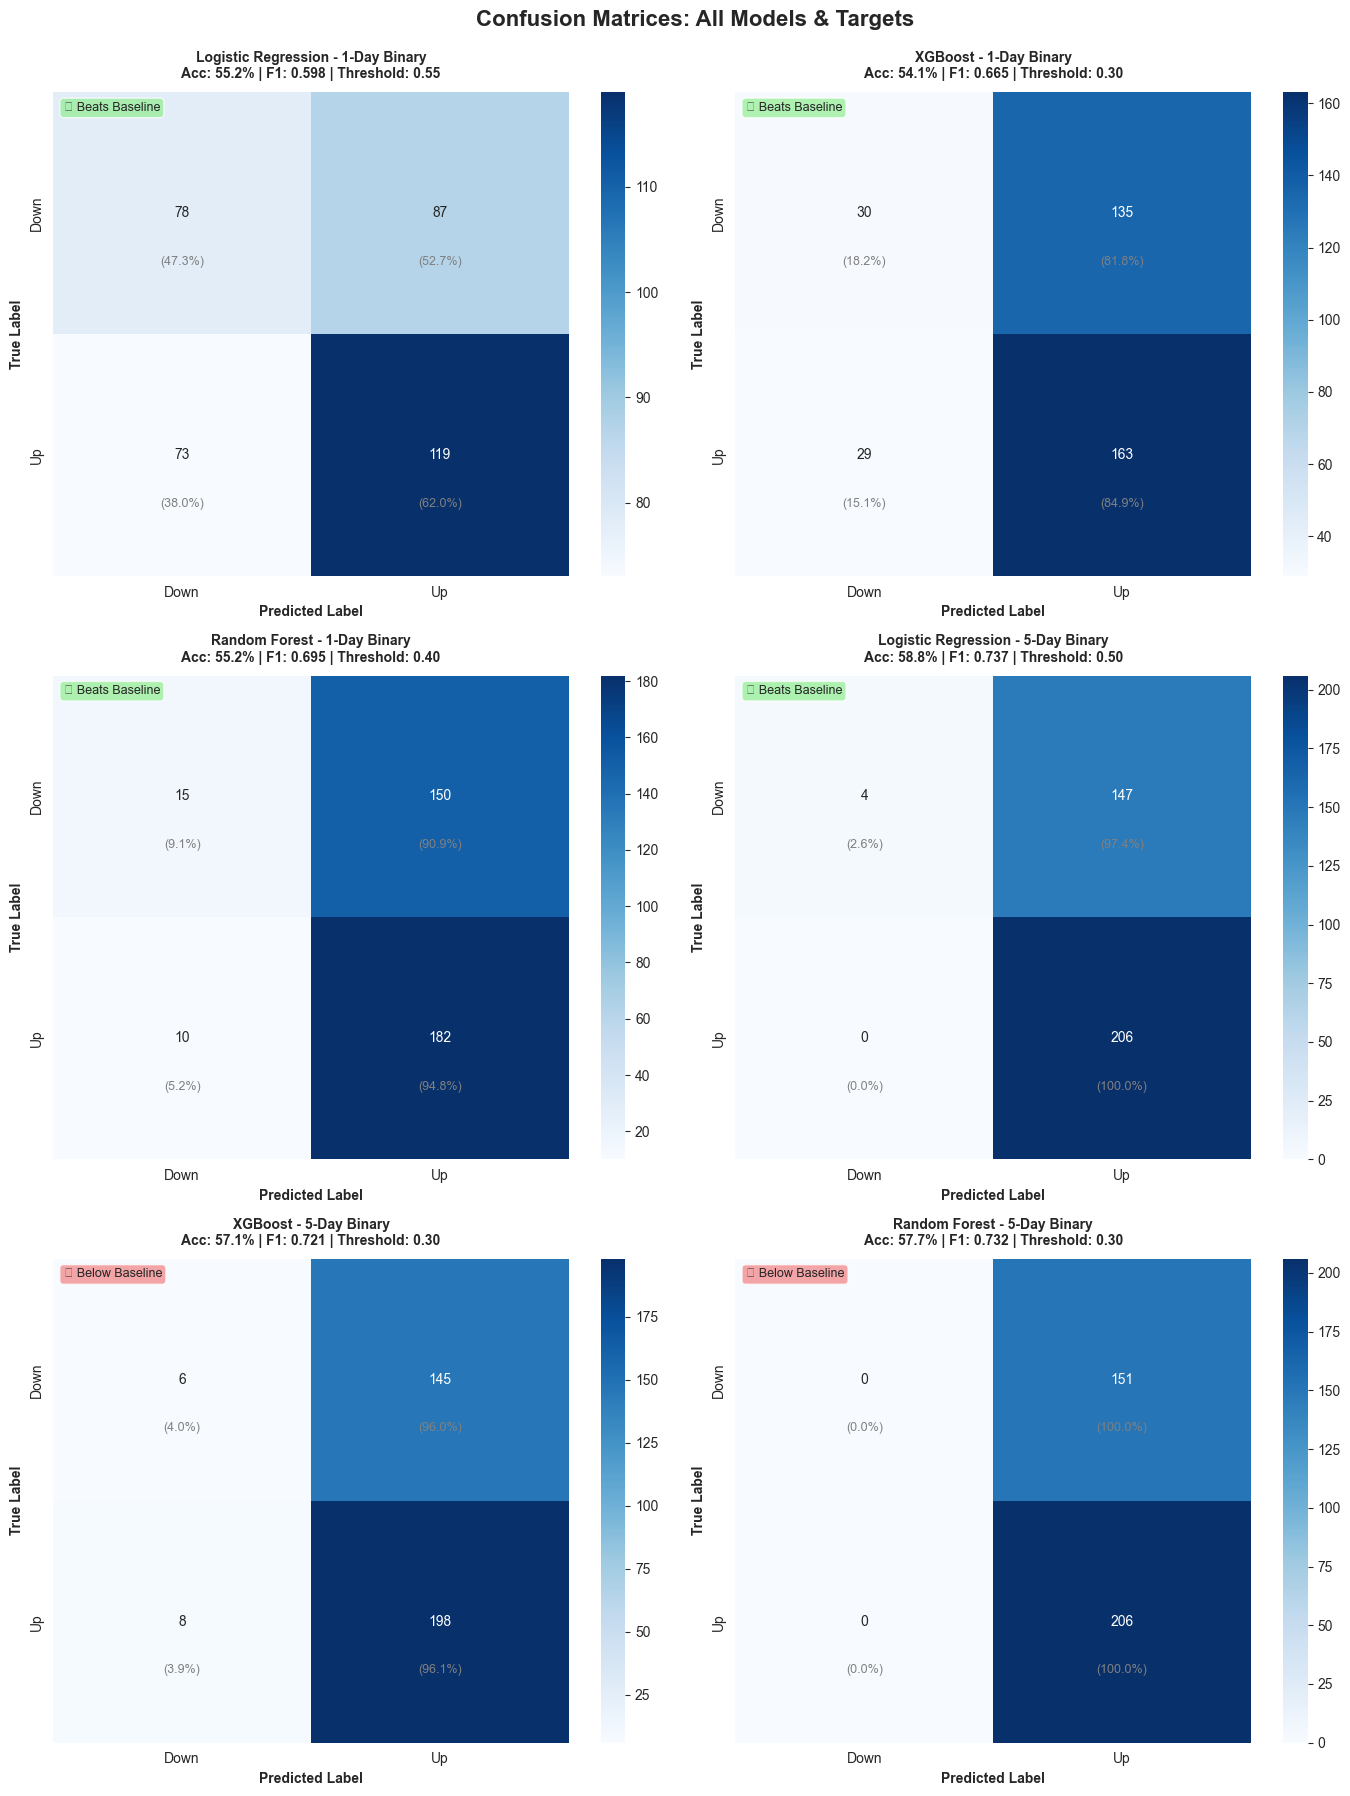


📊 All confusion matrices displayed!


In [17]:
# Plot all confusion matrices
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
fig.suptitle('Confusion Matrices: All Models & Targets', fontsize=16, fontweight='bold', y=0.995)

for idx, result in enumerate(all_results):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    cm = result['Confusion Matrix']
    
    # Normalize for better visualization
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Down', 'Up'],
                yticklabels=['Down', 'Up'],
                cbar=True)
    
    # Add percentages
    for i in range(2):
        for j in range(2):
            ax.text(j + 0.5, i + 0.7, f'({cm_norm[i, j]:.1%})', 
                   ha='center', va='center', fontsize=9, color='gray')
    
    # Title with metrics
    title = f"{result['Model']} - {result['Target']}\n"
    title += f"Acc: {result['Accuracy']:.1%} | F1: {result['F1 Score']:.3f} | Threshold: {result['Threshold']:.2f}"
    ax.set_title(title, fontsize=10, fontweight='bold', pad=10)
    ax.set_ylabel('True Label', fontweight='bold')
    ax.set_xlabel('Predicted Label', fontweight='bold')
    
    # Add baseline indicator
    if result['Beats Baseline']:
        ax.text(0.02, 0.98, '✅ Beats Baseline', transform=ax.transAxes,
               fontsize=9, va='top', ha='left',
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    else:
        ax.text(0.02, 0.98, '❌ Below Baseline', transform=ax.transAxes,
               fontsize=9, va='top', ha='left',
               bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n📊 All confusion matrices displayed!")

## 6. Detailed Analysis by Target

In [19]:
# Group by target
for target in ['1-Day Binary', '5-Day Binary']:
    print("\n" + "="*120)
    print(f" "*45 + f"ANALYSIS: {target}")
    print("="*120)
    
    target_results = results_df[results_df['Target'] == target].copy()
    
    # Sort by accuracy
    target_results = target_results.sort_values('Accuracy', ascending=False)
    
    print("\n📊 PERFORMANCE RANKING:")
    print("-"*120)
    for i, row in enumerate(target_results.itertuples(), 1):
        print(f"\n{i}. {row.Model}")
        print(f"   Threshold: {row.Threshold:.2f}")
        print(f"   Accuracy:  {row.Accuracy:.4f} ({row.Accuracy*100:.2f}%)")
        print(f"   Precision: {row.Precision:.4f}")
        print(f"   Recall:    {row.Recall:.4f}")
       # print(f"   F1 Score:  {getattr(row, 'F1 Score'):.4f}")
        print(f"   Baseline:  {row.Baseline:.4f} ({row.Baseline*100:.2f}%)")
        print(f"   vs Baseline: {row._10:+.4f} ({row._10*100:+.2f}%)")
        print(f"   Status: {row._11}")
    
    # Best model
    best = target_results.iloc[0]
    print("\n" + "*"*120)
    print(f"🏆 WINNER FOR {target}: {best['Model']}")
    print("*"*120)
    print(f"   Accuracy: {best['Accuracy']:.4f} ({best['Accuracy']*100:.2f}%)")
    print(f"   F1 Score: {best['F1 Score']:.4f}")
    print(f"   Improvement: {best['vs Baseline']*100:+.2f}% over baseline")
    print("*"*120)


                                             ANALYSIS: 1-Day Binary

📊 PERFORMANCE RANKING:
------------------------------------------------------------------------------------------------------------------------

1. Logistic Regression
   Threshold: 0.55
   Accuracy:  0.5518 (55.18%)
   Precision: 0.5777
   Recall:    0.6198
   Baseline:  0.5378 (53.78%)


ValueError: Unknown format code 'f' for object of type 'str'

## 7. Overall Winner & Insights

In [ ]:
print("\n" + "="*120)
print(" "*40 + "🏆 OVERALL ANALYSIS & INSIGHTS")
print("="*120)

# Find best overall model
best_overall = results_df.iloc[0]
print(f"\n🥇 BEST OVERALL MODEL:")
print(f"   {best_overall['Model']} on {best_overall['Target']}")
print(f"   Accuracy: {best_overall['Accuracy']:.4f} ({best_overall['Accuracy']*100:.2f}%)")
print(f"   F1 Score: {best_overall['F1 Score']:.4f}")
print(f"   Threshold: {best_overall['Threshold']:.2f}")
print(f"   Improvement: {best_overall['vs Baseline']*100:+.2f}% over baseline")

# Models that beat baseline
beating_baseline = results_df[results_df['Beats Baseline'] == '✅']
print(f"\n✅ MODELS BEATING BASELINE: {len(beating_baseline)}/{len(results_df)}")
for _, row in beating_baseline.iterrows():
    print(f"   • {row['Model']} ({row['Target']}): {row['Accuracy']:.1%} (baseline: {row['Baseline']:.1%})")

# Best per target
print(f"\n📊 BEST MODEL PER TARGET:")
for target in ['1-Day Binary', '5-Day Binary']:
    best_for_target = results_df[results_df['Target'] == target].iloc[0]
    print(f"   • {target}: {best_for_target['Model']} ({best_for_target['Accuracy']:.1%}, F1={best_for_target['F1 Score']:.3f})")

# Best per model
print(f"\n🤖 BEST TARGET PER MODEL:")
for model in results_df['Model'].unique():
    best_for_model = results_df[results_df['Model'] == model].sort_values('Accuracy', ascending=False).iloc[0]
    print(f"   • {model}: {best_for_model['Target']} ({best_for_model['Accuracy']:.1%}, F1={best_for_model['F1 Score']:.3f})")

# F1 Score analysis
print(f"\n📈 F1 SCORE RANKING:")
f1_sorted = results_df.sort_values('F1 Score', ascending=False)
for i, row in enumerate(f1_sorted.itertuples(), 1):
    print(f"   {i}. {row.Model} ({row.Target}): F1={getattr(row, 'F1 Score'):.4f}")

# Key insights
print(f"\n💡 KEY INSIGHTS:")
print(f"   1. Average Accuracy (All Models): {results_df['Accuracy'].mean():.1%}")
print(f"   2. Average F1 Score (All Models): {results_df['F1 Score'].mean():.3f}")
print(f"   3. Best Accuracy: {results_df['Accuracy'].max():.1%}")
print(f"   4. Best F1 Score: {results_df['F1 Score'].max():.3f}")
print(f"   5. Models beating baseline: {len(beating_baseline)}/{len(results_df)} ({len(beating_baseline)/len(results_df)*100:.0f}%)")

# Target comparison
target_1d_avg = results_df[results_df['Target'] == '1-Day Binary']['Accuracy'].mean()
target_5d_avg = results_df[results_df['Target'] == '5-Day Binary']['Accuracy'].mean()
print(f"\n🎯 TARGET DIFFICULTY:")
print(f"   • 1-Day Binary avg accuracy: {target_1d_avg:.1%}")
print(f"   • 5-Day Binary avg accuracy: {target_5d_avg:.1%}")
if target_1d_avg > target_5d_avg:
    print(f"   → 1-Day predictions are EASIER (by {(target_1d_avg - target_5d_avg)*100:.2f}%)")
else:
    print(f"   → 5-Day predictions are EASIER (by {(target_5d_avg - target_1d_avg)*100:.2f}%)")

print("\n" + "="*120)

## 8. Save Comprehensive Results

In [ ]:
# Save results to CSV
results_df_save = results_df.drop(columns=['Beats Baseline']).copy()
results_df_save.to_csv('../results/comprehensive_model_comparison.csv', index=False)
print("✅ Results saved to: ../results/comprehensive_model_comparison.csv")

# Create detailed report
with open('../results/model_comparison_report.txt', 'w') as f:
    f.write("="*120 + "\n")
    f.write(" "*35 + "COMPREHENSIVE MODEL COMPARISON REPORT\n")
    f.write(" "*30 + "Speech-Only Features: All Models, All Targets\n")
    f.write("="*120 + "\n\n")
    
    f.write("DATASET INFORMATION:\n")
    f.write("-"*120 + "\n")
    f.write(f"Total Samples: {len(df)}\n")
    f.write(f"Training Samples: {len(X_train)}\n")
    f.write(f"Testing Samples: {len(X_test)}\n")
    f.write(f"Features: {len(feature_cols)} (speech-only, market features removed)\n")
    f.write(f"Date Range: {df['date'].min().date()} to {df['date'].max().date()}\n\n")
    
    f.write("OVERALL RESULTS:\n")
    f.write("-"*120 + "\n")
    f.write(results_df.to_string(index=False))
    f.write("\n\n")
    
    f.write("BEST OVERALL MODEL:\n")
    f.write("-"*120 + "\n")
    f.write(f"Model: {best_overall['Model']}\n")
    f.write(f"Target: {best_overall['Target']}\n")
    f.write(f"Accuracy: {best_overall['Accuracy']:.4f} ({best_overall['Accuracy']*100:.2f}%)\n")
    f.write(f"F1 Score: {best_overall['F1 Score']:.4f}\n")
    f.write(f"Threshold: {best_overall['Threshold']:.2f}\n")
    f.write(f"Improvement over Baseline: {best_overall['vs Baseline']*100:+.2f}%\n\n")
    
    f.write("MODELS BEATING BASELINE:\n")
    f.write("-"*120 + "\n")
    for _, row in beating_baseline.iterrows():
        f.write(f"• {row['Model']} ({row['Target']}): {row['Accuracy']:.1%} (baseline: {row['Baseline']:.1%})\n")
    
    f.write("\n" + "="*120 + "\n")

print("✅ Report saved to: ../results/model_comparison_report.txt")
print("\n🎉 Comprehensive analysis complete!")